# Semantic Segmentation for Self-Driving Cars

Semantic Segmentation is an Image Classification task where you a label **each pixel** of an image with a corresponding **class** that it belongs to. For example, the "Traffic Signs" are represnted by a yellow mask over them, while the "lamp posts" are represnted by a blue mask.

![](./images/segmentation.png)

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import imageio

import tensorflow as tf
import tensorflow.keras.layers as tfl


## Loading and Preprocessing the Data

The dataset was generated as a part of the Lyft Udacity
 Challenge. It has input images and labelled semantic segmentations captures via CARLA self-driving car simulator. We load the data and reduce its input dimensions from $(600, 800, 3)$ to $(96, 128, 3)$ which will be much easier to train.

In [2]:
dataset_path = os.path.join(os.path.expanduser('~') + "/Downloads/datasets/semantic-segmentation-dataset/dataA/dataA/")
image_path = os.path.join(dataset_path + "CameraRGB/")
seg_path = os.path.join(dataset_path + "CameraSeg/")

image_list = os.listdir(image_path)
seg_list = os.listdir(seg_path)
image_list = [image_path+i for i in image_list]
seg_list = [seg_path+i for i in seg_list]

In [3]:
img_filenames = tf.constant(image_list)
seg_filenames = tf.constant(seg_list)

dataset = tf.data.Dataset.from_tensor_slices((img_filenames, seg_filenames))
for image, seg in dataset.take(1):
    print(image, "\n", seg)

tf.Tensor(b'/home/roland/Downloads/datasets/semantic-segmentation-dataset/dataA/dataA/CameraRGB/F2-50.png', shape=(), dtype=string) 
 tf.Tensor(b'/home/roland/Downloads/datasets/semantic-segmentation-dataset/dataA/dataA/CameraSeg/F2-50.png', shape=(), dtype=string)


In [4]:
IMAGE_DIMS_ORIGINAL = (600, 800, 3)
IMAGE_DIMS =  (96, 128, 3) 

def process_paths(img_path, seg_path):
    """Returns a (m,n, 3) dimensional image and a (m,n,1) dimensional segmentation mask. 
    We reduce the number of channels of the segmenetaion map to 1, thus now each pixel of
    the image represents a class from 0 to 12
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    seg = tf.io.read_file(seg_path)
    seg = tf.image.decode_png(seg, channels=3)
    #plt.imshow(seg[:,:,0])
    seg = tf.math.reduce_max(seg, axis=-1, keepdims=True) 
    #plt.imshow(tf.keras.preprocessing.image.array_to_img(seg))

    return img, seg
# for image, seg in dataset.take(10):
#     process_paths(image, seg)

def preprocess(img, seg):
    """Reduces the dimensions of the img and the segmentation mask. Also normalizes the inputs.
    """
    img_p = tf.image.resize(img, (96, 128), method='nearest') # Cant pass in global varialbes, throws warning
    img_p = img_p / 255

    seg_p = tf.image.resize(seg, (96, 128), method='nearest')

    return img_p, seg_p

image_ds = dataset.map(process_paths)
processed_image_ds = image_ds.map(preprocess)

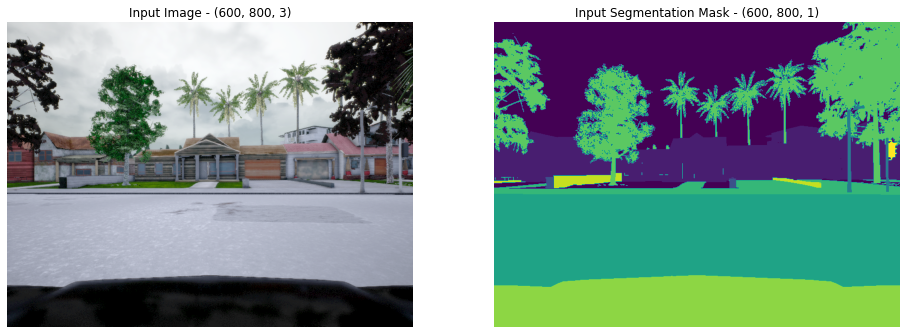

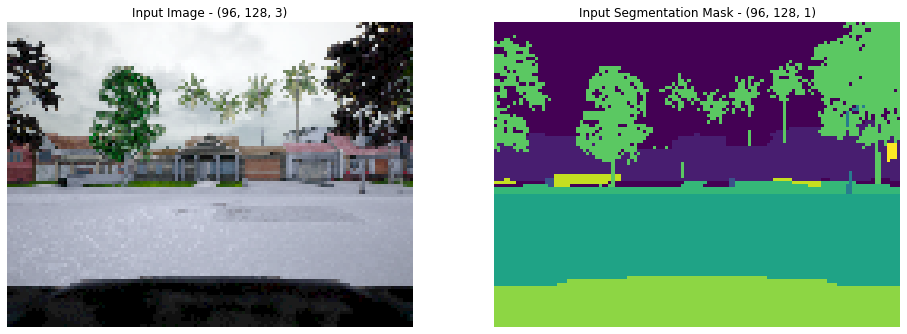

In [5]:
def plot_image(image_list):
    fig, ax = plt.subplots(1,len(image_list), figsize=(16, 12))

    title = ['Input Image', 'Input Segmentation Mask', 'Predicted Segmentation Mask']
    for i in range(len(image_list)):
        ax[i].imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        ax[i].set_title(title[i] + " - " + str(image_list[i].shape))
        ax[i].axis('off')
    plt.show()

for img, seg in image_ds.take(1):
    plot_image([img, seg])

for img, seg in processed_image_ds.take(1):
    plot_image([img, seg])

## U-Net Architecture

The U-Net Architecture was primarily designed to help medical professionals to spot tumours and other such irregularities in an organ. But it was later applied to other segmentation tasks and achieved great results. The U-Net Architecture is made up of 2 major components, an **encoder** and a **decoder**.

The encoder consists of multiple **downsampling_blocks.** They use normal **Convolutional Layers** to reduces the spatial dimensions of the input on every step.
The decoder on the other hands, consists of multiple **upsampling blocks.** They use **Transpose Convolutional Layers** which increases the spatial dimensions on every step.
The corresponding **downsampling_blocks** are connected by **Residual Layers** which transfer **lower level information** like the edges of leaf etc., from the encoder to the decoder.

![](./images/u-net.png)

In [6]:
def downsampling_block(inputs, n_filters, kernel_size = (3,3), dropout_rate = 0, max_pooling = True):
    """Consists of a stack of 2 Conv2D layers with ReLU activation. MaxPooling2D layer can be 
    turned off for the last block since, we need to apply Conv2DTranspose to the final block.
    It returns the output of the final Conv2D layer as `skip_connection`. The output of the
    MaxPooling2D layer is stored in `next_layer`.
    """

    conv = tfl.Conv2D(filters = n_filters,
                kernel_size = kernel_size,
                activation = 'relu',
                padding = 'same',
                kernel_initializer='he_normal')(inputs)

    conv = tfl.Conv2D(filters = n_filters,
                kernel_size = kernel_size,
                activation = 'relu',
                padding = 'same',
                kernel_initializer='he_normal')(conv)

    # Add a Dropout layer if dropout_rate > 0
    if dropout_rate > 0:
        conv = tfl.Dropout(rate = dropout_rate)(conv)

    skip_connection = conv
    
    # Add a MaxPooling2D layer with pool_size = (2,2) if max_pooling = True, else return
    # the previous otuput as next_layer
    if max_pooling: 
        next_layer = tfl.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv
    
    #print("Next: ", next_layer.shape, "Skip : ", skip_connection.shape)
    return next_layer, skip_connection

In [7]:
def upsampling_block(inputs, skip_inputs, n_filters, kernel_size=(3,3)):
    """Consists of a Con2DTranspose layer which increases the spatial dimension of the inputs, which
    is then concatenated with skip_inputs. Its followed by 2 Conv2D layer.
    """
    #print("Inputs: ", inputs.shape, "Skip :", skip_inputs.shape)
    transpose = tfl.Conv2DTranspose(filters = n_filters,
                                kernel_size = kernel_size,
                                strides = (2,2),
                                padding = 'same')(inputs)
    #print("Trans: ", transpose.shape)
    
    concat = tfl.concatenate([transpose, skip_inputs], axis=3)

    conv = tfl.Conv2D(filters = n_filters,
                    kernel_size = kernel_size,
                    activation = 'relu',
                    padding = 'same',
                    kernel_initializer='he_normal')(concat)

    conv = tfl.Conv2D(filters = n_filters,
                    kernel_size = kernel_size,
                    activation = 'relu',
                    padding = 'same',
                    kernel_initializer='he_normal')(conv)
    #print("Conv :", conv.shape)
    return conv

In [13]:
def unet(n_filters = 32, n_classes=13):
    """Combines the downsampling and upsampling blocks to create a U-Net. The final layer is a 1x1 
    convolution with # of filter = # of classes. Thus each channel will tell if a pixel belongs
    to a particular class or not.
    """
    
    inputs = tfl.Input(IMAGE_DIMS)

    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters*2)
    dblock3 = downsampling_block(dblock2[0], n_filters*4)
    dblock4 = downsampling_block(dblock3[0], n_filters*8)
    dblock5 = downsampling_block(dblock4[0], n_filters*16, dropout_rate=0.3, max_pooling=False)

    ublock4 = upsampling_block(dblock5[0], dblock4[1], n_filters*8)
    ublock3 = upsampling_block(ublock4, dblock3[1], n_filters*4)
    ublock2 = upsampling_block(ublock3, dblock2[1], n_filters*2)
    ublock1 = upsampling_block(ublock2, dblock1[1], n_filters)

    conv = tfl.Conv2D(filters = n_filters,
                    kernel_size = (3,3),
                    activation = 'relu',
                    padding = 'same',
                    kernel_initializer='he_normal')(ublock1)

    conv = tfl.Conv2D(filters = n_classes,
                    kernel_size = (1,1),
                    padding = 'same')(conv)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv)
    return model

In [14]:
unet_model = unet()
unet_model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 96, 128, 32)  896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_41[0][0]                  
____________________________________________________________________________________________

In [114]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
unet_model_history = unet_model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/20
32/32 [==============================] - 88s 3s/step - loss: 1.9633 - accuracy: 0.3139
Epoch 2/20
32/32 [==============================] - 77s 2s/step - loss: 1.5674 - accuracy: 0.4320
Epoch 3/20
32/32 [==============================] - 78s 2s/step - loss: 1.0293 - accuracy: 0.6007
Epoch 4/20
32/32 [==============================] - 76s 2s/step - loss: 0.7809 - accuracy: 0.6952
Epoch 5/20
32/32 [==============================] - 77s 2s/step - loss: 0.6599 - accuracy: 0.7665
Epoch 6/20
32/32 [==============================] - 76s 2s/step - loss: 0.5964 - accuracy: 0.7814
Epoch 7/20
32/32 [==============================] - 80s 3s/step - loss: 0.5777 - accuracy: 0.7804
Epoch 8/20
32/32 [==============================] - 80s 3s/step - loss: 0.5571 - accuracy: 0.7915
Epoch 9/20
32/32 [==============================] - 83s 3s/step - loss: 0.5455 - accuracy: 0.8009
Epoch 10/20
32/32 [==============================] - 83s 3s/step - loss: 0.5087 - accuracy: 0.8223
Epoch 11/20
32/32 [

In [115]:
def create_mask(pred_mask):
    """Takes the final output of the model, which is (m,n, # of classes) and converts
    it to (m,n,1). It finds the index of the largest predition in the last dimenion (#of classes). 
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

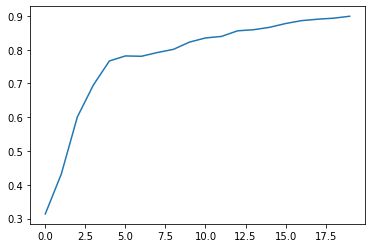

In [116]:
plt.plot(unet_model_history.history["accuracy"])

In [119]:
def show_predictions(dataset=train_dataset, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        plot_image([image[0], mask[0], create_mask(pred_mask[0])])
        
        #conf = tf.math.confusion_matrix(mask[0].shape, create_mask(pred_mask[0]).shape)


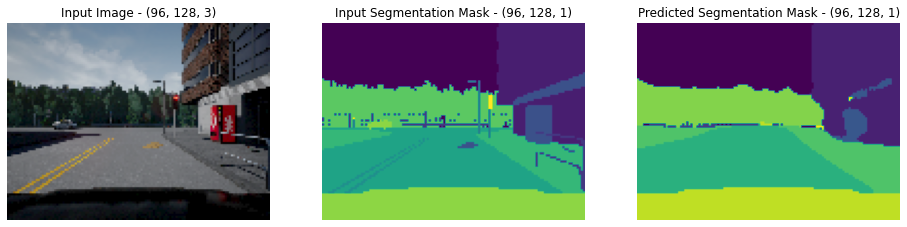

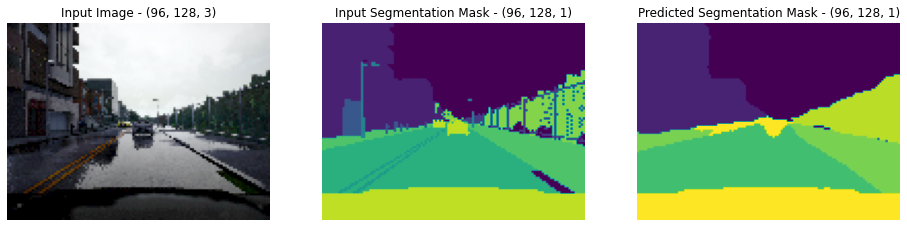

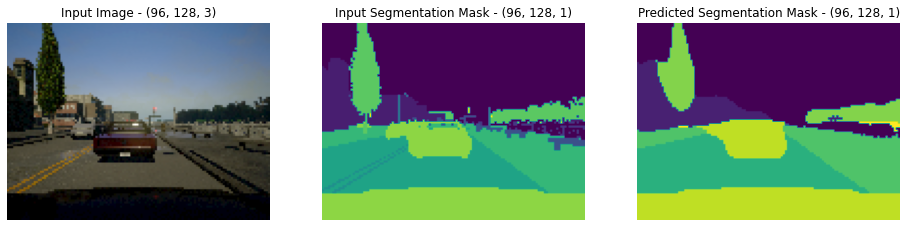

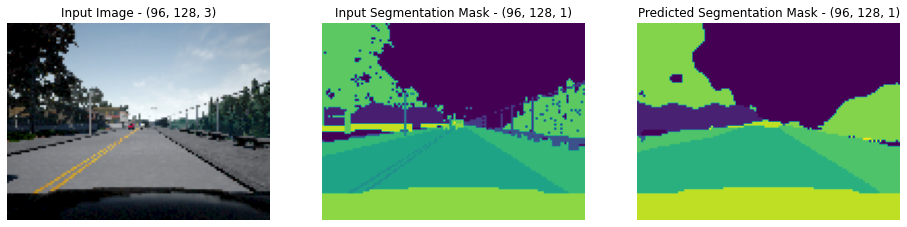

In [120]:
show_predictions(num=4)